In [1]:
from IPython.display import Image

# 从全连接层到卷积
:label:`sec_why-conv`

我们之前讨论的多层感知机十分适合处理表格数据，其中行对应样本，列对应特征。
对于表格数据，我们寻找的模式可能涉及特征之间的交互，但是我们不能预先假设任何与特征交互相关的先验结构。
此时，多层感知机可能是最好的选择，然而对于高维感知数据，这种缺少结构的网络可能会变得不实用。

例如，在之前猫狗分类的例子中：假设我们有一个足够充分的照片数据集，数据集中是拥有标注的照片，每张照片具有百万级像素，这意味着网络的每次输入都有一百万个维度。
即使将隐藏层维度降低到1000，这个全连接层也将有$10^6 \times 10^3 = 10^9$个参数。
想要训练这个模型将不可实现，因为需要有大量的GPU、分布式优化训练的经验和超乎常人的耐心。

有些读者可能会反对这个观点，认为要求百万像素的分辨率可能不是必要的。
然而，即使分辨率减小为十万像素，使用1000个隐藏单元的隐藏层也可能不足以学习到良好的图像特征，在真实的系统中我们仍然需要数十亿个参数。
此外，拟合如此多的参数还需要收集大量的数据。
然而，如今人类和机器都能很好地区分猫和狗：这是因为图像中本就拥有丰富的结构，而这些结构可以被人类和机器学习模型使用。
*卷积神经网络*（convolutional neural networks，CNN）是机器学习利用自然图像中一些已知结构的创造性方法。

## 不变性

想象一下，假设我们想从一张图片中找到某个物体。
合理的假设是：无论哪种方法找到这个物体，都应该和物体的位置无关。
理想情况下，我们的系统应该能够利用常识：猪通常不在天上飞，飞机通常不在水里游泳。
但是，如果一只猪出现在图片顶部，我们还是应该认出它。
我们可以从儿童游戏”沃尔多在哪里”（ :numref:`img_waldo`）中得到灵感：
在这个游戏中包含了许多充斥着活动的混乱场景，而沃尔多通常潜伏在一些不太可能的位置，读者的目标就是找出他。
尽管沃尔多的装扮很有特点，但是在眼花缭乱的场景中找到他也如大海捞针。
然而沃尔多的样子并不取决于他潜藏的地方，因此我们可以使用一个“沃尔多检测器”扫描图像。
该检测器将图像分割成多个区域，并为每个区域包含沃尔多的可能性打分。
卷积神经网络正是将*空间不变性*（spatial invariance）的这一概念系统化，从而基于这个模型使用较少的参数来学习有用的表示。

![沃尔多游戏示例图。](../img/where-wally-walker-books.jpg)
:width:`400px`
:label:`img_waldo`

现在，我们将上述想法总结一下，从而帮助我们设计适合于计算机视觉的神经网络架构。

### 1. 平移不变性（translation invariance）
不管检测对象出现在图像中的哪个位置，神经网络的前面几层应该对相同的图像区域具有相似的反应，即为“平移不变性”。

1）*核心思想：*

我们关心的目标（特征）在输入数据中出现的位置，不应该影响系统识别出它的能力。

2）*通俗理解：*

想象一个“猫检测器”。无论一只猫出现在照片的左上角、正中央还是右下角，这个检测器都应该能认出它是一只猫。检测器所依赖的“猫的特征”（如胡须、耳朵、毛茸茸的纹理）是固有的，与猫在画面中的位置无关。

3）*在数学和网络设计中的体现：*

在全连接层中，每个位置的像素都连接到隐藏层的每个神经元，并且连接权重取决于像素的绝对位置。这意味着，识别左上角猫的神经元和识别右下角猫的神经元，其权重是独立、不共享的。
在卷积层中，我们使用一个称为卷积核（或滤波器）的小窗口，在整个输入图像上滑动。这个卷积核的权重是固定不变的。无论它滑动到图像的哪个区域，它都在用同一套权重来检测该局部区域是否具有它所代表的特征（比如边缘、角点、某种纹理）。

4）*例子说明：*

假设一个卷积核被训练用来检测“垂直边缘”。当它在图像左侧滑动时，它用权重 W 来寻找垂直边缘；当它滑动到图像右侧时，它仍然使用完全相同的权重 W 来寻找垂直边缘。这就是权重共享，它是实现平移不变性的关键技术。

5）*带来的好处：*

参数效率：网络不需要为每个位置都学习一套独立的特征检测器，大大减少了模型参数。

泛化能力：模型学会了“什么是猫”，而不是“在(10,20)坐标位置的东西是什么”。这使得模型能更好地识别训练集中未出现过位置的猫。

符合先验：这与我们对视觉世界的认知是一致的——物体的身份通常与其位置无关。

### 2. 局部性（locality）
神经网络的前面几层应该只探索输入图像中的局部区域，而不过度在意图像中相隔较远区域的关系，这就是“局部性”原则。最终，可以聚合这些局部特征，以在整个图像级别进行预测。

1）核心思想： 

要理解一个像素（或一个数据点），我们只需要观察它周围一个有限的局部区域，而不需要立即关注整个图像的每一个细节。

2）通俗理解：

当你看一页书时，要看清一个字，你只需要聚焦于这个字及其周围几个字。你不需要同时看清整页的所有文字才能理解你正在看的那个字。同样，要判断一个像素是否属于猫的胡须，你只需要看它周围那些代表胡须纹理的像素，而不需要同时去看远处的猫尾巴。

3）在数学和网络设计中的体现：

在全连接层中，每个隐藏神经元都连接到整个输入图像的所有像素。一个在计算“鼻子”特征的神经元，也会受到远处“尾巴”像素的直接影响。

在卷积层中，每个隐藏神经元（即特征图上的一个点 [H]_{i, j}）只连接到输入图像的一个小区域（即感受野），这个区域由卷积核的大小 Δ 决定。例如，一个3x3的卷积核，输出特征图上的每个点只受输入图像上对应3x3区域的影响。


让我们看看这些原则是如何转化为数学表示的。

## 多层感知机的限制

首先，多层感知机的输入是二维图像$\mathbf{X}$，其隐藏表示$\mathbf{H}$在数学上是一个矩阵，在代码中表示为二维张量。
其中$\mathbf{X}$和$\mathbf{H}$具有相同的形状。
为了方便理解，我们可以认为，无论是输入还是隐藏表示都拥有空间结构。

“隐藏表示”指的是输入图像经过网络一层变换后得到的中间结果或特征图。

使用$[\mathbf{X}]_{i, j}$和$[\mathbf{H}]_{i, j}$分别表示输入图像和隐藏表示中位置（$i$,$j$）处的像素。
为了使每个隐藏神经元都能接收到每个输入像素的信息，我们将参数从权重矩阵（如同我们先前在多层感知机中所做的那样）替换为四阶权重张量$\mathsf{W}$。假设$\mathbf{U}$包含偏置参数，我们可以将全连接层形式化地表示为

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$

其中，从$\mathsf{W}$到$\mathsf{V}$的转换只是形式上的转换，因为在这两个四阶张量的元素之间存在一一对应的关系。
我们只需重新索引下标$(k, l)$，使$k = i+a$、$l = j+b$，由此可得$[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$。
索引$a$和$b$通过在正偏移和负偏移之间移动覆盖了整个图像。
对于隐藏表示中任意给定位置（$i$,$j$）处的像素值$[\mathbf{H}]_{i, j}$，可以通过在$x$中以$(i, j)$为中心对像素进行加权求和得到，加权使用的权重为$[\mathsf{V}]_{i, j, a, b}$。

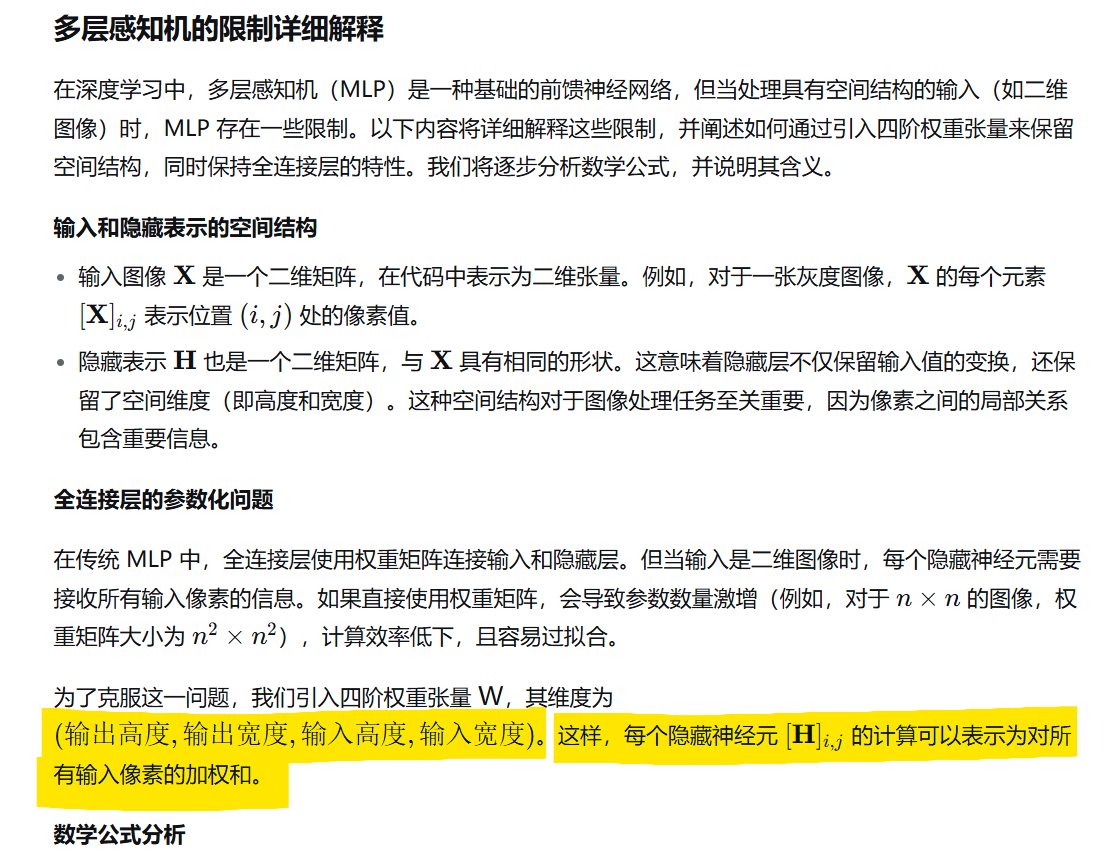

In [7]:
Image(filename= r'./pic1.png', width= 500, height= 1000)

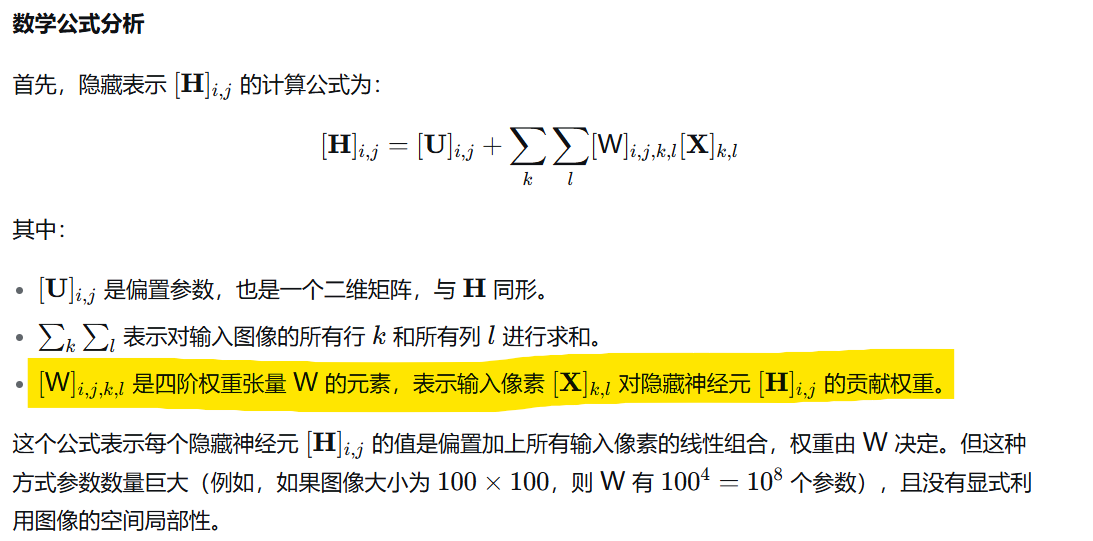

In [8]:
Image(filename= r'./pic2.png', width= 500, height= 1000)

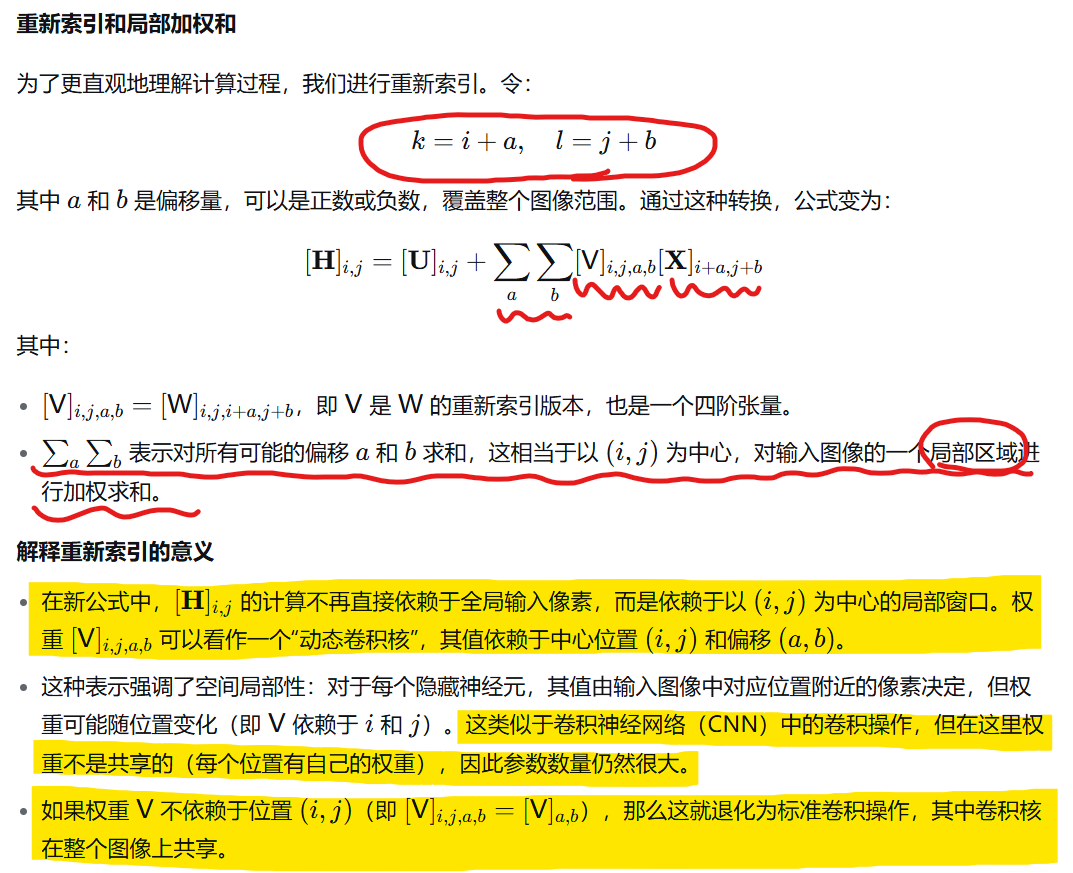

In [9]:
Image(filename= r'./pic3.png', width= 500, height= 1000)

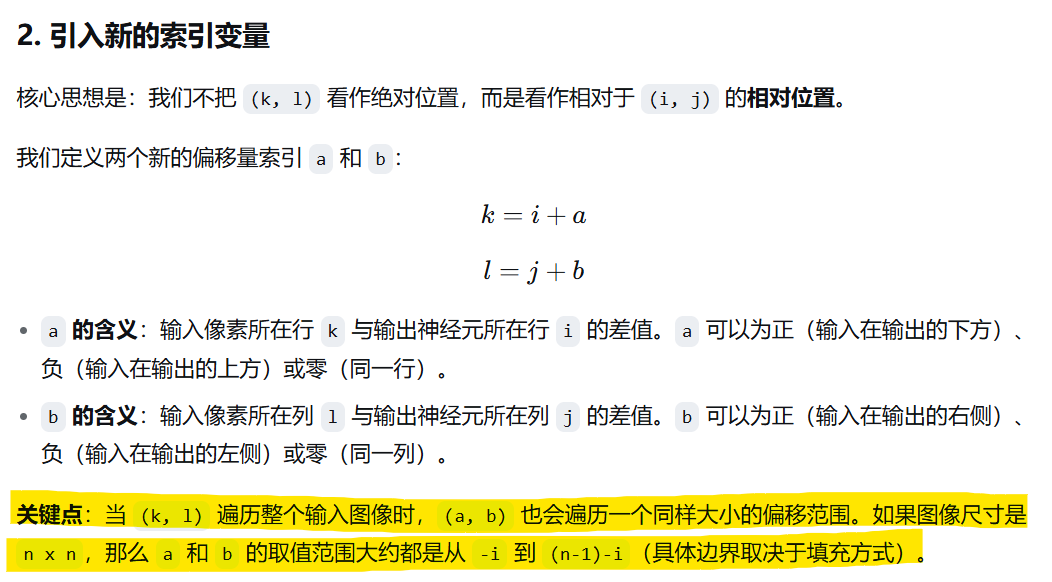

In [10]:
Image(filename= r'./pic3-1.png', width= 500, height= 1000)

### 平移不变性

现在引用上述的第一个原则：平移不变性。
这意味着检测对象在输入$\mathbf{X}$中的平移，应该仅导致隐藏表示$\mathbf{H}$中的平移。也就是说，$\mathsf{V}$和$\mathbf{U}$实际上不依赖于$(i, j)$的值，即$[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$。并且$\mathbf{U}$是一个常数，比如$u$。因此，我们可以简化$\mathbf{H}$定义为：

$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}.$$

这就是*卷积*（convolution）。我们是在使用系数$[\mathbf{V}]_{a, b}$对位置$(i, j)$附近的像素$(i+a, j+b)$进行加权得到$[\mathbf{H}]_{i, j}$。
注意，$[\mathbf{V}]_{a, b}$的系数比$[\mathsf{V}]_{i, j, a, b}$少很多，因为前者不再依赖于图像中的位置。这就是显著的进步！

### 局部性

现在引用上述的第二个原则：局部性。如上所述，为了收集用来训练参数$[\mathbf{H}]_{i, j}$的相关信息，我们不应偏离到距$(i, j)$很远的地方。这意味着在$|a|> \Delta$或$|b| > \Delta$的范围之外，我们可以设置$[\mathbf{V}]_{a, b} = 0$。因此，我们可以将$[\mathbf{H}]_{i, j}$重写为

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$
:eqlabel:`eq_conv-layer`

简而言之， :eqref:`eq_conv-layer`是一个*卷积层*（convolutional layer），而卷积神经网络是包含卷积层的一类特殊的神经网络。
在深度学习研究社区中，$\mathbf{V}$被称为*卷积核*（convolution kernel）或者*滤波器*（filter），亦或简单地称之为该卷积层的*权重*，通常该权重是可学习的参数。
当图像处理的局部区域很小时，卷积神经网络与多层感知机的训练差异可能是巨大的：以前，多层感知机可能需要数十亿个参数来表示网络中的一层，而现在卷积神经网络通常只需要几百个参数，而且不需要改变输入或隐藏表示的维数。
参数大幅减少的代价是，我们的特征现在是平移不变的，并且当确定每个隐藏活性值时，每一层只包含局部的信息。
以上所有的权重学习都将依赖于归纳偏置。当这种偏置与现实相符时，我们就能得到样本有效的模型，并且这些模型能很好地泛化到未知数据中。
但如果这偏置与现实不符时，比如当图像不满足平移不变时，我们的模型可能难以拟合我们的训练数据。


*什么是归纳偏置：* 指的是我们为了让机器学习模型更好地学习而预先注入的一些假设或偏好。CNN的归纳偏置就是平移不变性和局部性。

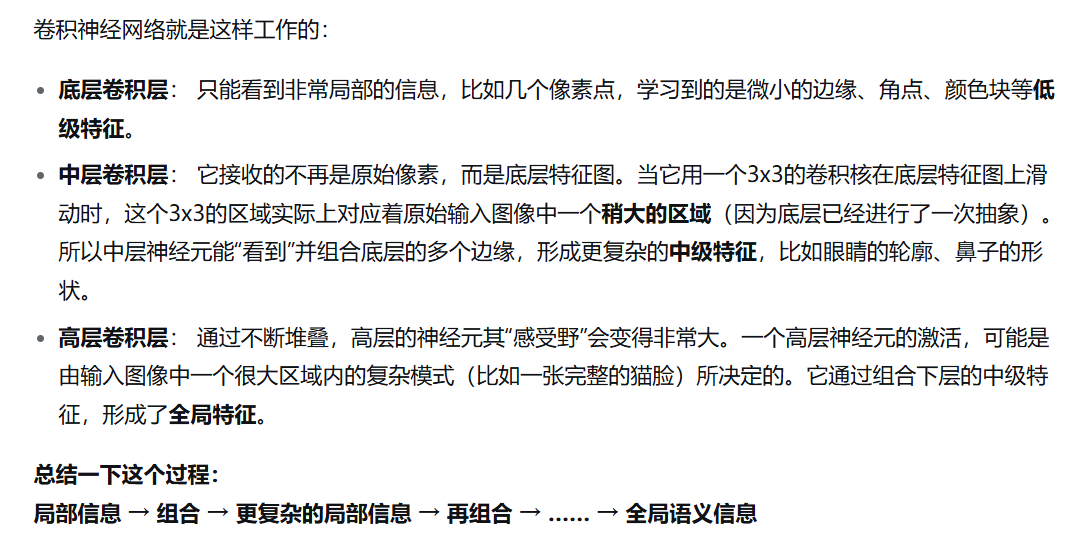

In [11]:
Image(filename= r'./pic4.png', width= 500, height= 1000)


## 卷积

在进一步讨论之前，我们先简要回顾一下为什么上面的操作被称为卷积。在数学中，两个函数（比如$f, g: \mathbb{R}^d \to \mathbb{R}$）之间的“卷积”被定义为

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$

也就是说，卷积是当把一个函数“翻转”并移位$\mathbf{x}$时，测量$f$和$g$之间的重叠。
当为离散对象时，积分就变成求和。例如，对于由索引为$\mathbb{Z}$的、平方可和的、无限维向量集合中抽取的向量，我们得到以下定义：

$$(f * g)(i) = \sum_a f(a) g(i-a).$$

对于二维张量，则为$f$的索引$(a, b)$和$g$的索引$(i-a, j-b)$上的对应加和：

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b).$$
:eqlabel:`eq_2d-conv-discrete`

这看起来类似于 :eqref:`eq_conv-layer`，但有一个主要区别：这里不是使用$(i+a, j+b)$，而是使用差值。然而，这种区别是表面的，因为我们总是可以匹配 :eqref:`eq_conv-layer`和 :eqref:`eq_2d-conv-discrete`之间的符号。我们在 :eqref:`eq_conv-layer`中的原始定义更正确地描述了*互相关*（cross-correlation），这个问题将在下一节中讨论。

## “沃尔多在哪里”回顾

回到上面的“沃尔多在哪里”游戏，让我们看看它到底是什么样子。卷积层根据滤波器$\mathbf{V}$选取给定大小的窗口，并加权处理图片，如 :numref:`fig_waldo_mask`中所示。我们的目标是学习一个模型，以便探测出在“沃尔多”最可能出现的地方。

![发现沃尔多。](../img/waldo-mask.jpg)
:width:`400px`
:label:`fig_waldo_mask`

### 通道
:label:`subsec_why-conv-channels`

然而这种方法有一个问题：我们忽略了图像一般包含三个通道/三种原色（红色、绿色和蓝色）。
实际上，图像不是二维张量，而是一个由高度、宽度和颜色组成的三维张量，比如包含$1024 \times 1024 \times 3$个像素。
前两个轴与像素的空间位置有关，而第三个轴可以看作每个像素的多维表示。
因此，我们将$\mathsf{X}$索引为$[\mathsf{X}]_{i, j, k}$。由此卷积相应地调整为$[\mathsf{V}]_{a,b,c}$，而不是$[\mathbf{V}]_{a,b}$。

此外，由于输入图像是三维的，我们的隐藏表示$\mathsf{H}$也最好采用三维张量。
换句话说，对于每一个空间位置，我们想要采用一组而不是一个隐藏表示。这样一组隐藏表示可以想象成一些互相堆叠的二维网格。
因此，我们可以把隐藏表示想象为一系列具有二维张量的*通道*（channel）。
这些通道有时也被称为*特征映射*（feature maps），因为每个通道都向后续层提供一组空间化的学习特征。
直观上可以想象在靠近输入的底层，一些通道专门识别边缘，而一些通道专门识别纹理。

### 从"看到"到"理解"的转变
#### 输入通道（如RGB）：

1.红色通道：只记录"有多红"

2.绿色通道：只记录"有多绿"

3.蓝色通道：只记录"有多蓝"

#### 输出通道（特征映射）：

1.边缘通道：记录"这里有多像边缘"

2.纹理通道：记录"这里有多像纹理"

3.角点通道：记录"这里有多像角点"

为了支持输入$\mathsf{X}$和隐藏表示$\mathsf{H}$中的多个通道，我们可以在$\mathsf{V}$中添加第四个坐标，即$[\mathsf{V}]_{a, b, c, d}$。综上所述，

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},$$
:eqlabel:`eq_conv-layer-channels`

其中隐藏表示$\mathsf{H}$中的索引$d$表示输出通道，而随后的输出将继续以三维张量$\mathsf{H}$作为输入进入下一个卷积层。
所以， :eqref:`eq_conv-layer-channels`可以定义具有多个通道的卷积层，而其中$\mathsf{V}$是该卷积层的权重。

然而，仍有许多问题亟待解决。
例如，图像中是否到处都有存在沃尔多的可能？如何有效地计算输出层？如何选择适当的激活函数？为了训练有效的网络，如何做出合理的网络设计选择？我们将在本章的其它部分讨论这些问题。


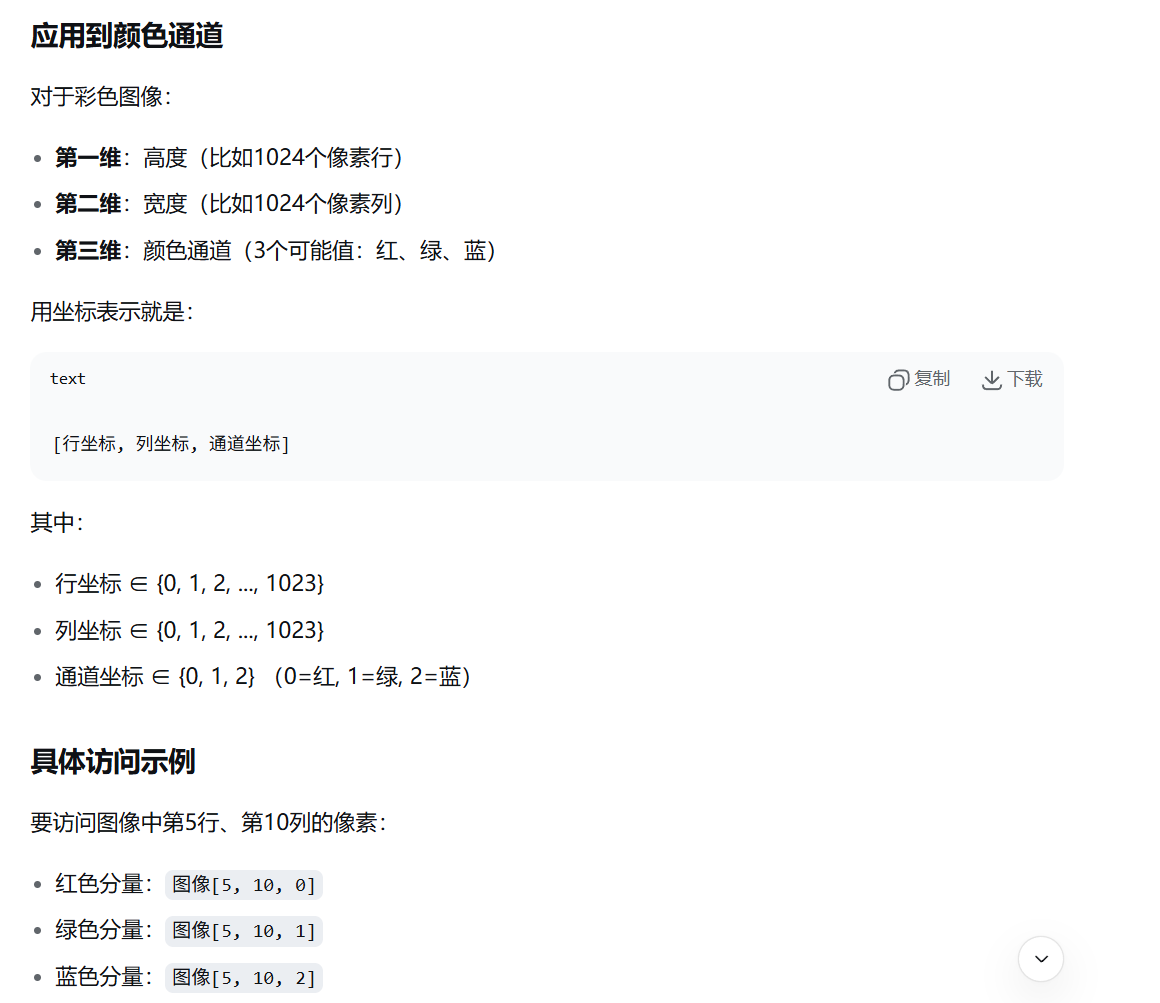

In [12]:
Image(filename=r'./pic5.png', width=500, height=1000)

## 小结

- 图像的平移不变性使我们以相同的方式处理局部图像，而不在乎它的位置。
- 局部性意味着计算相应的隐藏表示只需一小部分局部图像像素。
- 在图像处理中，卷积层通常比全连接层需要更少的参数，但依旧获得高效用的模型。
- 卷积神经网络（CNN）是一类特殊的神经网络，它可以包含多个卷积层。
- 多个输入和输出通道使模型在每个空间位置可以获取图像的多方面特征。

## 练习

1. 假设卷积层 :eqref:`eq_conv-layer`覆盖的局部区域$\Delta = 0$。在这种情况下，证明卷积内核为每组通道独立地实现一个全连接层。
1. 为什么平移不变性可能也不是好主意呢？
1. 当从图像边界像素获取隐藏表示时，我们需要思考哪些问题？
1. 描述一个类似的音频卷积层的架构。
1. 卷积层也适合于文本数据吗？为什么？
1. 证明在 :eqref:`eq_2d-conv-discrete`中，$f * g = g * f$。

[Discussions](https://discuss.d2l.ai/t/5767)